In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
import os
os.makedirs('models', exist_ok=True)

In [5]:
from sklearn.metrics import root_mean_squared_error

In [6]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("my-experiment")

2025/07/16 10:20:37 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/16 10:20:37 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025/07/16 10:20:37 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-Experiment Tracking/mlruns/1', creation_time=1752018549946, experiment_id='1', last_update_time=1752018549946, lifecycle_stage='active', name='my-experiment', tags={}>

In [7]:
path1 = './yellow_tripdata_2024-01.parquet'
path2 = './yellow_tripdata_2024-02.parquet'

In [8]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    #df.head()
    df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    # filter
    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    
    df[categorical] = df[categorical].astype(str) #int -> str
    
    return df


In [9]:
df_train = read_dataframe(path1).sample(10000, random_state=1)
df_val = read_dataframe(path2).sample(10000, random_state=1)

In [10]:
#td = df.duration.iloc[0]
#td.total_seconds()
#df.duration.describe(percentiles=[0.95, 0.98, 0.99])
#numerical = ['trip_distance']
#df[categorical].dtypes
#len(df_train) == len(df_val)

In [11]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [12]:
#categorical = ['PULocationID', 'DOLocationID']
categorical = ['PU_DO']
numerical = ['trip_distance']

dv = DictVectorizer() #DictVectorizer는 딕셔너리 형태의 데이터를 머신러닝 모델이 사용할 수 있는 행렬(벡터)로 변환합니다.

#DataFrame에서 범주형(categorical)과 수치형(numerical) 컬럼만 선택해, 각 행을 딕셔너리로 변환합니다.
#결과는 딕셔너리의 리스트가 됩니다. (예: [{'col1': val1, 'col2': val2, ...}, ...])
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

#fit_transform은 학습과 변환을 동시에 수행합니다.
#X_train은 변환된 특성 행렬(2차원 배열, sparse matrix)입니다.
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

#예측하고자 하는 목표값(여기서는 'duration' 컬럼)을 y_train에 저장합니다.
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values



In [13]:
#선형회귀 모델을 생성하고, X_train(특성)과 y_train(목표값)으로 학습시킵니다.
lr = LinearRegression()
lr.fit(X_train, y_train)

#학습된 모델로 X_train에 대한 예측값을 구합니다.
y_pred = lr.predict(X_train)

#회귀 문제에서 예측값과 실제값의 차이를 제곱해 평균을 낸 값(MSE, 평균제곱오차)을 계산
mean_squared_error(y_train, y_pred)

14.595657517143144

/tmp/ipykernel_32107/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_32107/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')
/tmp/ipykernel_32107/1672306066.py:2: UserWarning: 

`distplot` is a deprec

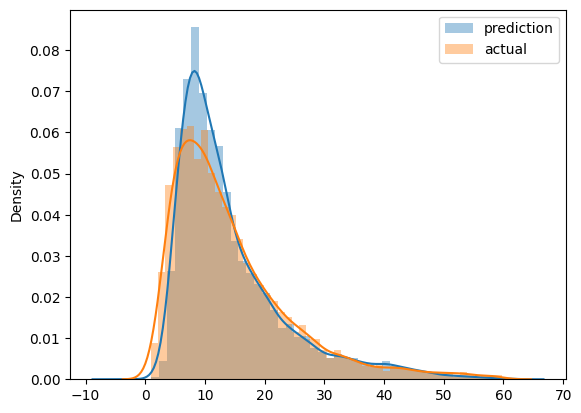

In [14]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [15]:


with mlflow.start_run():
    mlflow.set_tag("dev", "josh")
    mlflow.log_param("train-data-path", path1)
    mlflow.log_param("val-data-path", path2)
    
    alpha = 0.001
    mlflow.log_param("alpha", alpha)
    lr = Ridge(alpha) 
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_train)
    rmse = root_mean_squared_error(y_train, y_pred)
    mlflow.log_metric("rmse", rmse)

    # save the model
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models")

In [16]:
#'models/lin_reg.bin' 파일을 바이너리 쓰기 모드('wb')로 엽니다.
# pickle.dump((dv, lr), f_out)는 dv와 lr 객체를 튜플로 묶어 파일에 저장합니다.
#with open('models/lin_reg.bin', 'wb') as f_out:
#    pickle.dump((dv, lr), f_out)    

In [17]:
import xgboost as xgb
# 최적의 hyper parameter set을 찾기 위해 Bayesian Optimization을 사용하는 라이브러리
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll import scope

In [18]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [19]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("models", "xgboost")
        if isinstance(params, dict):
            for k, v in params.items():
                mlflow.log_param(k, v)
        else:
            mlflow.log_param("params", params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals=[(valid, 'validation')],
            early_stopping_rounds=10
        )

        # 예측 및 RMSE 계산
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        
        # 메트릭 기록
        mlflow.log_metric("rmse", rmse)
        return {'loss': rmse, 'status': STATUS_OK}

In [20]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[0]	validation-rmse:6.05326                           
[0]	validation-rmse:6.05326                           
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:20:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:5.75373                           
[1]	validation-rmse:5.753730<?, ?trial/s, best loss=?]
[2]	validation-rmse:5.70941                           
[2]	validation-rmse:5.70941                           
[3]	validation-rmse:5.68545                           
[3]	validation-rmse:5.68545                           
[4]	validation-rmse:5.67928                           
[4]	validation-rmse:5.67928                           
[5]	validation-rmse:5.68014                           
[5]	validation-rmse:5.68014                           
[6]	validation-rmse:5.68323                           
[6]	validation-rmse:5.68323                           
[7]	validation-rmse:5.67935                           
[7]	validation-rmse:5.67935                           
[8]	validation-rmse:5.68090                           
[8]	validation-rmse:5.68090                           
[9]	validation-rmse:5.68113                           
  0%|          | 0/50 [00:01<?, ?trial/s, best loss=?][9]	validat

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:21:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.36951                                                    
[1]	validation-rmse:9.369513<02:48,  3.44s/trial, best loss: 5.680518626802372]
[2]	validation-rmse:9.01088                                                    
[2]	validation-rmse:9.01088                                                    
[3]	validation-rmse:8.68371                                                    
[3]	validation-rmse:8.68371                                                    
[4]	validation-rmse:8.38651                                                    
[4]	validation-rmse:8.38651                                                    
[5]	validation-rmse:8.11524                                                    
[5]	validation-rmse:8.11524                                                    
[6]	validation-rmse:7.86976                                                    
[6]	validation-rmse:7.86976                                                    
[7]	validation-rmse:7.64857             

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:21:07] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.63771                                                    
[1]	validation-rmse:8.637711<04:34,  5.72s/trial, best loss: 5.663662875358818]
[2]	validation-rmse:8.05399                                                    
[2]	validation-rmse:8.05399                                                    
[3]	validation-rmse:7.57581                                                    
[3]	validation-rmse:7.57581                                                    
[4]	validation-rmse:7.18437                                                    
[4]	validation-rmse:7.18437                                                    
[5]	validation-rmse:6.86866                                                    
[5]	validation-rmse:6.86866                                                    
[6]	validation-rmse:6.61749                                                    
[6]	validation-rmse:6.61749                                                    
[7]	validation-rmse:6.41702             

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:21:15] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.54955                                                    
[1]	validation-rmse:7.549559<05:15,  6.71s/trial, best loss: 5.663662875358818]
[2]	validation-rmse:6.84244                                                    
[2]	validation-rmse:6.84244                                                    
[3]	validation-rmse:6.39237                                                    
[3]	validation-rmse:6.39237                                                    
[4]	validation-rmse:6.11091                                                    
[4]	validation-rmse:6.11091                                                    
[5]	validation-rmse:5.93646                                                    
[5]	validation-rmse:5.93646                                                    
[6]	validation-rmse:5.83751                                                    
[6]	validation-rmse:5.83751                                                    
[7]	validation-rmse:5.77896             

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:21:20] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.76251                                                    
[0]	validation-rmse:9.762514<04:31,  5.90s/trial, best loss: 5.663662875358818]
[1]	validation-rmse:9.36898                                                    
[1]	validation-rmse:9.36898                                                    
[2]	validation-rmse:9.01024                                                    
[2]	validation-rmse:9.01024                                                    
[3]	validation-rmse:8.68056                                                    
[3]	validation-rmse:8.68056                                                    
[4]	validation-rmse:8.38124                                                    
[4]	validation-rmse:8.38124                                                    
[5]	validation-rmse:8.11340                                                    
[5]	validation-rmse:8.11340                                                    
[6]	validation-rmse:7.86928             

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:21:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.13924                                                    
[0]	validation-rmse:7.139244<11:06, 14.82s/trial, best loss: 5.663662875358818]
 10%|█         | 5/50 [00:55<08:21, 11.15s/trial, best loss: 5.663662875358818]



KeyboardInterrupt: 

In [21]:
if mlflow.active_run() is not None:
    mlflow.end_run()

mlflow.start_run() 없이도 mlflow의 일부 함수(예: log_param, log_metric 등)는 내부적으로 자동으로 run을 시작하기 때문에 작동할 수 있습니다.
하지만 명시적으로 with mlflow.start_run():을 사용하는 것이 더 안전하고, 실험의 시작과 끝을 명확하게 관리할 수 있습니다.

권장 사항:

여러 실험을 반복하거나, 코드가 복잡해질수록 명시적으로 start_run을 사용하는 것이 좋습니다.
자동 run에 의존하면 중첩 run, 여러 셀 실행 시 예기치 않은 에러가 발생할 수 있습니다.
정리:
꼭 필요하지는 않지만, 실무/협업/재현성 측면에서 with mlflow.start_run():을 사용하는 것이 가장 안전한 방법입니다.

Exception: Run with UUID 67af706581064a84b11ba83b38bdee13 is already active. To start a new run, first end the current run with mlflow.end_run(). To start a nested run, call start_run with nested=True

이 에러는 mlflow에서 이미 실행 중인 run이 끝나지 않은 상태에서 새로운 run을 시작하려고 할 때 발생합니다.

해결 방법:

새로운 run을 시작하기 전에 mlflow.end_run()을 호출해 현재 run을 명시적으로 종료하세요.
또는, start_run(nested=True)로 중첩 run을 허용할 수 있습니다.

In [22]:
mlflow.xgboost.autolog(disable=True)

with mlflow.start_run():
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    params = {
        'max_depth': 8,
        'learning_rate': 0.3505001399438667,
        'reg_alpha': 0.03931781860170088,
        'reg_lambda': 0.3002990958721907,
        'min_child_weight': 4.658981377254529,
        'objective': 'reg:linear',
        'seed': 42
    }
    mlflow.log_params(params)

    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=100,
        evals=[(valid, 'validation')],
        early_stopping_rounds=10
    )

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="models")

    mlflow.xgboost.log_model(booster, artifact_path="model_mlflow", input_example=X_val[0:1])
    # sample이 없으면 WARNING mlflow.models.model: Model logged without a signature and input example. Please set input_example parameter when logging the model to auto infer the model signature.



[0]	validation-rmse:7.93054
[1]	validation-rmse:6.73767
[2]	validation-rmse:6.15961


[3]	validation-rmse:5.88579
[4]	validation-rmse:5.76505
[5]	validation-rmse:5.70719
[6]	validation-rmse:5.68044
[7]	validation-rmse:5.66304
[8]	validation-rmse:5.65277


/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:22:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[9]	validation-rmse:5.64651
[10]	validation-rmse:5.64098
[11]	validation-rmse:5.63973
[12]	validation-rmse:5.63806
[13]	validation-rmse:5.63769
[14]	validation-rmse:5.63754
[15]	validation-rmse:5.63573
[16]	validation-rmse:5.63344
[17]	validation-rmse:5.63176
[18]	validation-rmse:5.63155
[19]	validation-rmse:5.63010
[20]	validation-rmse:5.62750
[21]	validation-rmse:5.62739
[22]	validation-rmse:5.62619
[23]	validation-rmse:5.62635
[24]	validation-rmse:5.62429
[25]	validation-rmse:5.62333
[26]	validation-rmse:5.62112
[27]	validation-rmse:5.62115
[28]	validation-rmse:5.62168
[29]	validation-rmse:5.62028
[30]	validation-rmse:5.62028
[31]	validation-rmse:5.62069
[32]	validation-rmse:5.61903
[33]	validation-rmse:5.61931
[34]	validation-rmse:5.61816
[35]	validation-rmse:5.61785
[36]	validation-rmse:5.61803
[37]	validation-rmse:5.61718
[38]	validation-rmse:5.61702
[39]	validation-rmse:5.61722
[40]	validation-rmse:5.61565
[41]	validation-rmse:5.61457
[42]	validation-rmse:5.61365
[43]	validation

2025/07/16 10:22:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [10:22:09] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


In [ ]:

logged_model = "runs:/b0986655af9b47828349c8c3d0b14f18/model_mlflow"
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model



mlflow.pyfunc.loaded_model:
  artifact_path: /workspaces/mlops-zoomcamp/02-Experiment Tracking/mlruns/1/models/m-05588181529940eeac4c7a55f13b6c49/artifacts
  flavor: mlflow.xgboost
  run_id: b0986655af9b47828349c8c3d0b14f18

In [25]:
xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

In [ ]:
import pandas as pd
loaded_model.predict(pd.DataFrame(data))

MlflowException: Failed to enforce schema of data '         VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
993329          2  2024-02-10 22:11:48   2024-02-10 22:34:23              1.0   
1853028         2  2024-02-20 13:25:37   2024-02-20 13:53:55              1.0   
1429329         2  2024-02-15 17:59:57   2024-02-15 18:05:19              1.0   
588845          2  2024-02-07 08:10:16   2024-02-07 08:16:21              1.0   
371005          2  2024-02-04 17:03:25   2024-02-04 17:06:22              1.0   
...           ...                  ...                   ...              ...   
515470          1  2024-02-06 12:52:52   2024-02-06 13:04:40              1.0   
2841173         1  2024-02-05 13:47:38   2024-02-05 13:53:06              NaN   
805246          2  2024-02-09 09:44:40   2024-02-09 10:02:05              2.0   
1577173         2  2024-02-17 02:29:36   2024-02-17 02:33:31              1.0   
2309521         2  2024-02-24 21:33:33   2024-02-24 21:57:13              1.0   

         trip_distance  RatecodeID store_and_fwd_flag PULocationID  \
993329           12.51         2.0                  N          132   
1853028           8.33         1.0                  N          138   
1429329           0.70         1.0                  N          263   
588845            0.92         1.0                  N          238   
371005            0.60         1.0                  N          186   
...                ...         ...                ...          ...   
515470            1.60         1.0                  N          161   
2841173           0.70         NaN               None          239   
805246            2.59         1.0                  N          166   
1577173           0.96         1.0                  N          107   
2309521           4.43         1.0                  N          239   

        DOLocationID  payment_type  ...  extra  mta_tax  tip_amount  \
993329           129             2  ...    0.0      0.5        0.00   
1853028          166             1  ...    5.0      0.5        7.98   
1429329          263             1  ...    2.5      0.5        0.00   
588845           239             1  ...    0.0      0.5        2.38   
371005            90             1  ...    0.0      0.5        6.00   
...              ...           ...  ...    ...      ...         ...   
515470            43             1  ...    2.5      0.5        3.10   
2841173          142             0  ...    0.0      0.5        2.10   
805246            42             2  ...    0.0      0.5        0.00   
1577173          233             1  ...    1.0      0.5        2.30   
2309521          137             2  ...    1.0      0.5        0.00   

         tolls_amount  improvement_surcharge  total_amount  \
993329           0.00                    1.0         73.25   
1853028          6.94                    1.0         61.17   
1429329          0.00                    1.0         13.00   
588845           0.00                    1.0         14.28   
371005           0.00                    1.0         15.10   
...               ...                    ...           ...   
515470           0.00                    1.0         18.50   
2841173          0.00                    1.0         12.60   
805246           0.00                    1.0         19.90   
1577173          0.00                    1.0         13.80   
2309521          0.00                    1.0         29.70   

         congestion_surcharge  Airport_fee   duration    PU_DO  
993329                    0.0         1.75  22.583333  132_129  
1853028                   0.0         1.75  28.300000  138_166  
1429329                   2.5         0.00   5.366667  263_263  
588845                    2.5         0.00   6.083333  238_239  
371005                    2.5         0.00   2.950000   186_90  
...                       ...          ...        ...      ...  
515470                    2.5         0.00  11.800000   161_43  
2841173                   NaN          NaN   5.466667  239_142  
805246                    0.0         0.00  17.416667   166_42  
1577173                   2.5         0.00   3.916667  107_233  
2309521                   2.5         0.00  23.666667  239_137  

[10000 rows x 21 columns]' with schema '[Tensor('float64', (-1, 2755))]'. Error: This model contains a model signature with an unnamed input. Since the input data is a pandas DataFrame containing multiple columns, the input shape must be of the structure (-1, number_of_dataframe_columns). Instead, the input DataFrame passed had 21 columns and an input shape of (-1, 2755) with all values within the DataFrame of scalar type. Please adjust the passed in DataFrame to match the expected structure

In [ ]:
y_pred = xgboost_model.predict(data)